In [1]:
include("paramless.jl")
using SpecialFunctions
using NumericalIntegration
using Plots
using Statistics

### Attempting to recreate scientist payoff game

In [2]:
function gaussian_j(q, q_threshold,ϵ)

    #edge cases:
    if q == q_threshold && ϵ==0.0
        return 0.5
    end
    result = 1.0 - ((1 + erf((q_threshold - q) / ϵ  / sqrt(2))) / 2)
    if isnan(result)    
        throw(error("Error computing gaussian_j: q = $q, q_threshold = $q_threshold, ϵ = $ϵ"))
    end
    return Float64(result)
end

gaussian_j (generic function with 1 method)

In [3]:
function heaviside(x)
    if x > 0 
        return 1 
    else 
        return 0
    end 
end 

heaviside (generic function with 1 method)

In [4]:
function payoff_scientist(q, q_threshold, c, ϵ, q_bar)
    #= 
    q = quality of scientist
    q_threshold = used to determine probability of acceptance 
    ϵ = noise generated by the journal 
    q_bar = average quality of the paper, has a role in the benefit  
    =#
    p = gaussian_j(q, q_threshold, ϵ)
    return max(p * q_bar - (1.0 - p) * c*q ,0)

    #=
    version 4 
        p * q_bar - (1.0-p)*q*c # Default to this 
    =#
end 

function payoff_curve(domain, q_t, c, ϵ, q_b)
    return [payoff_scientist(q, 
    q_t, 
    c, ϵ, 
    q_b) for q = domain]

end 

function average_q(domain, q_t, c, ϵ, q_b)
    return mean([q*heaviside(payoff_scientist(q, 
    q_t, 
    c, ϵ, 
    q_b)) for q = domain])
end 

function fuzzy_submission(domain, c, q_t,q_b, ϵ)
    return integrate(domain, payoff_curve(domain, q_t, c, ϵ, q_b))
end

function binary_submission(domain, c, q_t,q_b, ϵ)
    #=
    If payoff positive then submit = 1, else 0 
    =#
    return integrate(domain, map(heaviside,payoff_curve(domain, q_t, c, ϵ, q_b)))
end


function science_fitness(resident, mutant; kwargs...)
    if haskey(kwargs, :c)
        c = kwargs[:c]
    end 
    if haskey(kwargs, :domain)
        domain = kwargs[:domain]
    end
    if haskey(kwargs, :q_t)
        q_t = kwargs[:q_t]
    end
    if haskey(kwargs, :q_b)
        q_b = kwargs[:q_b]
    end
    if haskey(kwargs, :mutation_epsilon)
        mutation_epsilon = kwargs[:mutation_epsilon]
    end

    fitness_resident = submission(resident,domain, c, q_t,q_b, mutation_epsilon)
    fitness_mutant = submission(mutant,domain, c, q_t,q_b, mutation_epsilon)

    return fitness_resident, fitness_mutant

end

science_fitness (generic function with 1 method)

In [5]:
function mutation_journal_qt(param; kwargs...)
    is_inside = false
    attempt = 0
    mutant = param 

    if haskey(kwargs, :mutation_epsilon)
        mutation_epsilon = kwargs[:mutation_epsilon]
    end
    if haskey(kwargs, :lower_bound)
        lower_bound = kwargs[:lower_bound]
    else
        lower_bound = nothing
    end

    if haskey(kwargs, :upper_bound)
        upper_bound = kwargs[:upper_bound]
    else
        upper_bound = nothing
    end

    while !is_inside
        mutant = _attempt_mutation_journal_qt(param, mutation_epsilon) # Modify their DNA
        is_inside = _within_bounds_scalar(mutant, lower_bound, upper_bound) # Check if everything is contained
        attempt += 1

        if attempt > MAX_ITER
            throw(ErrorException("Attempted too many mutations without producing anythin within bounds"))
        end
    end
    return mutant
end


function _attempt_mutation_journal_qt(param, mutation_epsilon)
    return param + rand([-1,1],1)[1]*mutation_epsilon
end 

function fitness_journal_qt(resident, mutant; kwargs...)
    # Compute resident q_t 
    if haskey(kwargs, :c)
        c = kwargs[:c]
    end 
    if haskey(kwargs, :ϵ)
        ϵ = kwargs[:ϵ]
    end 
    if haskey(kwargs, :q_b)
        q_b = kwargs[:q_b]
    end 

    fitness_resident = average_q(domain, resident, c, ϵ, q_b)

    fitness_mutant = average_q(domain, mutant, c, ϵ, q_b)
    
    return fitness_resident, fitness_mutant 

    
end 

fitness_journal_qt (generic function with 1 method)

In [10]:
function mutation_journal_eps(param; kwargs...)
    is_inside = false
    attempt = 0
    mutant = param 

    if haskey(kwargs, :mutation_epsilon)
        mutation_epsilon = kwargs[:mutation_epsilon]
    end
    if haskey(kwargs, :lower_bound)
        lower_bound = kwargs[:lower_bound]
    else
        lower_bound = nothing
    end

    if haskey(kwargs, :upper_bound)
        upper_bound = kwargs[:upper_bound]
    else
        upper_bound = nothing
    end

    while !is_inside
        mutant = _attempt_mutation_journal_eps(param, mutation_epsilon) # Modify their DNA
        is_inside = _within_bounds_scalar(mutant, lower_bound, upper_bound) # Check if everything is contained
        attempt += 1

        if attempt > MAX_ITER
            throw(ErrorException("Attempted too many mutations without producing anythin within bounds"))
        end
    end
    return mutant

end


function _attempt_mutation_journal_eps(param, mutation_epsilon)
    return param + rand([-1,1],1)[1]*mutation_epsilon
end 

function fitness_journal_eps(resident, mutant; kwargs...)
    # Compute resident q_t 
    if haskey(kwargs, :c)
        c = kwargs[:c]
    end 
    if haskey(kwargs, :q_t)
        q_t = kwargs[:q_t]
    end 
    if haskey(kwargs, :q_b)
        q_b = kwargs[:q_b]
    end 

    fitness_resident = average_q(domain, q_t, c, resident, q_b)

    fitness_mutant = average_q(domain, q_t, c, mutant, q_b)
    
    return fitness_resident, fitness_mutant 

    
end 

fitness_journal_eps (generic function with 1 method)

In [22]:
ans, series = evolve(  
                     science_fitness, # need fitness, (submission?)
                     gaussian_mutation, # mutation is still gaussian 
                     5e4, # Try 1e5
                     atol=1e-12; # Unchanged
                     domain=domain, # same 
                     mutation_epsilon=0.01, 
                     c=0.2, 
                    width=0.02, 
                    lower_bound=0.0,
                    q_t = 0.2,
                    q_b = 0.8
                    ) # need extra arguments for cost q_t etc

([0.18483792961080506, 0.1883871805178287, 0.19194011526816862, 0.1954951024203324, 0.1990504644658948, 0.20260448122366687, 0.20615539354643128, 0.20970140733787432, 0.21324069787530078, 0.21677141443151865  …  0.9909909909910005, 0.9919919919920007, 0.9929929929930011, 0.9939939939940016, 0.994994994995002, 0.9959959959960024, 0.996996996997003, 0.9979979979980035, 0.9989989989990041, 1.0000000000000047], Any[Any[2.0, [0.0, 0.001001001001001001, 0.002002002002002002, 0.003003003003003003, 0.004004004004004004, 0.005005005005005005, 0.006006006006006006, 0.007007007007007007, 0.008008008008008008, 0.009009009009009009  …  0.990990990990991, 0.991991991991992, 0.992992992992993, 0.993993993993994, 0.994994994994995, 0.995995995995996, 0.996996996996997, 0.997997997997998, 0.998998998998999, 1.0]], Any[19.0, [0.009296735929987907, 0.010345417937396338, 0.011392597444349022, 0.012438249804199641, 0.01348235110504499, 0.014524878191050994, 0.015565808683173376, 0.01660512099924704, 0.0176

In [7]:
function journal_evolve(initial_surface, fitness_science, mutation_science, iterations, atol=DEF_ATOL, seed=0; kwargs...)
    """
    We evolve two things at once. This code is not modularised and is PoC 

    - Evolve the submission curve first π_scientist, not yet 
    - Evolve q_t, eps then check mutant
    """
    if haskey(kwargs, :param)
        param = kwargs[:param]
    end 

    if haskey(kwargs, :fitness_journal)
        fitness_journal = kwargs[:fitness_journal]
    end 

    if haskey(kwargs, :mutation_journal)
        mutation_journal = kwargs[:mutation_journal]
    end 

    if haskey(kwargs, :domain)
        domain = kwargs[:domain]
    end 

    if haskey(kwargs, :c)
        c = kwargs[:c]
    end 

    if haskey(kwargs, :q_t)
        q_t = kwargs[:q_t]
    end 

    Random.seed!(seed)
    last_entry_time = 0
    resident = deepcopy(initial_surface)


    seq = 0
    time_series = []

    previous_resident = zeros(size(initial_surface))
    previous_param = 0
    q_b = 0.4

    for step = 1:iterations

        previous_resident = deepcopy(resident)
        target_surface = payoff_curve(domain, q_t, c, param, q_b)
        resident, t = evolution_step(
            resident, fitness_science, mutation_science, atol; kwargs..., target_surface=target_surface)
        q_b = mean([domain[idx]*heaviside(resident[idx]) for idx=1:length(domain)])

        # Afterwards compute journal stuff
        previous_param = param 
        param, invasion = evolution_step(param, fitness_journal, mutation_journal, atol; kwargs...,q_b=q_b)

        if invasion 
            push!(time_series, [step - last_entry_time, previous_param])
        end 

    end
    return resident, param, time_series
end

journal_evolve (generic function with 3 methods)

In [30]:
function journal_evolve_v2(initial_surface, fitness_science, mutation_science, iterations, atol=DEF_ATOL, seed=0; kwargs...)
    """
    We evolve two things at once. This code is not modularised and is PoC 

    - Evolve the submission curve first π_scientist, not yet 
    - Evolve q_t, eps then check mutant
    """
    if haskey(kwargs, :param)
        param = kwargs[:param]
    end 

    if haskey(kwargs, :fitness_journal_1)
        fitness_journal_1 = kwargs[:fitness_journal_1]
    end 

    if haskey(kwargs, :mutation_journal_1)
        mutation_journal_1 = kwargs[:mutation_journal_1]
    end 

    if haskey(kwargs, :fitness_journal_2)
        fitness_journal_2 = kwargs[:fitness_journal_2]
    end 

    if haskey(kwargs, :mutation_journal_2)
        mutation_journal_2 = kwargs[:mutation_journal_2]
    end 

    if haskey(kwargs, :domain)
        domain = kwargs[:domain]
    end 

    if haskey(kwargs, :c)
        c = kwargs[:c]
    end 

    if haskey(kwargs, :q_t)
        q_t = kwargs[:q_t]
    end 

    if haskey(kwargs, :ϵ)
        ϵ = kwargs[:ϵ]
    end 


    Random.seed!(seed)
    last_entry_time = 0
    resident = deepcopy(initial_surface)


    seq = 0
    time_series_1 = []
    time_series_2 = []
    previous_resident = zeros(size(initial_surface))
    previous_param_1 = 0
    previous_param_2 = 0
    q_b = 0.4

    for step = 1:iterations

        previous_resident = deepcopy(resident)
        target_surface = payoff_curve(domain, q_t, c, ϵ, q_b)
        resident, t = evolution_step(
            resident, fitness_science, mutation_science, atol; kwargs..., target_surface=target_surface)
        q_b = mean([domain[idx]*heaviside(resident[idx]) for idx=1:length(domain)])

        # Afterwards compute journal stuff
        previous_param_1 = ϵ
        ϵ, invasion = evolution_step(ϵ, fitness_journal_1, mutation_journal_1, atol; kwargs...,q_b=q_b)

        if invasion 
            push!(time_series_1, [step - last_entry_time, previous_param_1])
        end 

        # Do qt then after 
        previous_param_2 = q_t 
        q_t, invasion = evolution_step(q_t, fitness_journal_2, mutation_journal_2, atol; kwargs...,q_b=q_b)

        if invasion 
            push!(time_series_2, [step - last_entry_time, previous_param_2])
        end 

    end
    return resident, ϵ, q_t, time_series_1, time_series_2
end

journal_evolve_v2 (generic function with 3 methods)

In [26]:
domain = Array(range(0.0,1.0,length=1000));
initial_surface = zeros(size(domain));

In [39]:
resident, eps , qt, time_series_1, time_series_2 = journal_evolve_v2(  
                    initial_surface,
                    distance_fitness_function, # need fitness, (submission?)
                     gaussian_mutation, # mutation is still gaussian 
                     5e5, # Try 1e5
                     atol=1e-12; # Unchanged
                     fitness_journal_1 = fitness_journal_eps,
                     mutation_journal_1 = mutation_journal_eps,
                     fitness_journal_2 = fitness_journal_qt,
                     mutation_journal_2 = mutation_journal_qt,
                     domain=domain, # same 
                     mutation_epsilon=0.001, 
                     c=0.6, 
                    width=0.02, 
                    lower_bound=0.0,
                    q_t = 0.05,
                    q_b = 0.1,
                    ϵ = 0.05
                    ) # need extra arguments for cost q_t etc

([0.07956494658261708, 0.08161260415297661, 0.08361707148085668, 0.08557327323230694, 0.08749337823951743, 0.08941500354505888, 0.09140644488031788, 0.09354963030523349, 0.09589085031346657, 0.09839400127597459  …  0.5003822654930574, 0.5006993024099846, 0.5006543696635128, 0.5004233937647937, 0.5000608898186556, 0.4988828574282277, 0.49618369793407124, 0.4923021270776618, 0.4882860324238578, 0.4847804528527848], 0.05, 0.05, Any[], Any[])

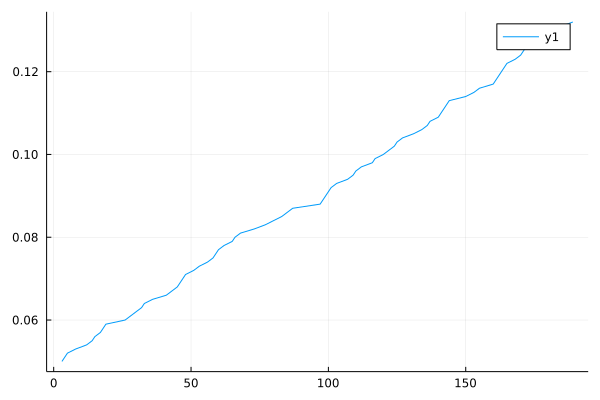

In [33]:
plot([a[1] for a = time_series_1],[a[2] for a = time_series_1])

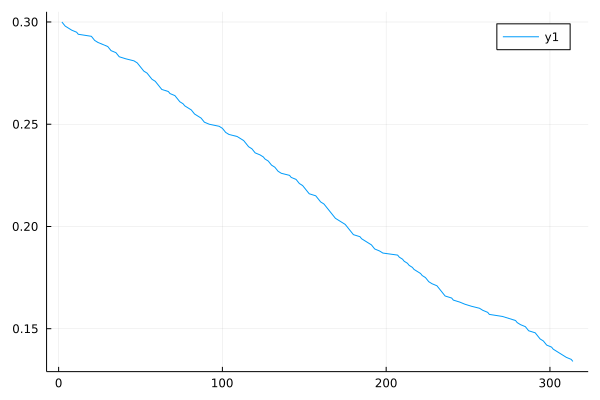

In [34]:
plot([a[1] for a = time_series_2],[a[2] for a = time_series_2])

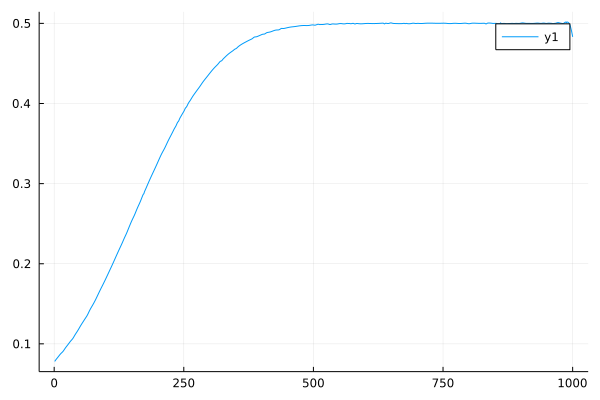

In [32]:
plot(resident)

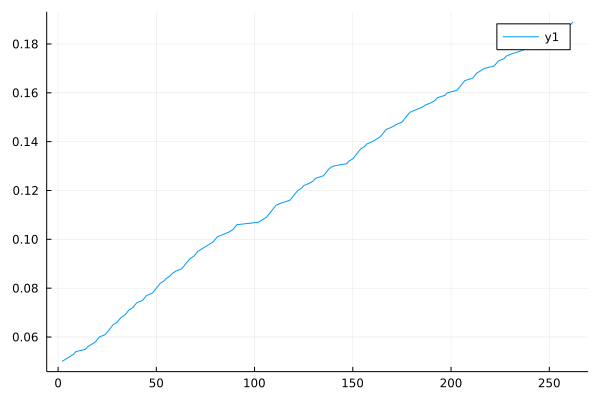

In [24]:
plot([a[1] for a = series],[a[2] for a = series])

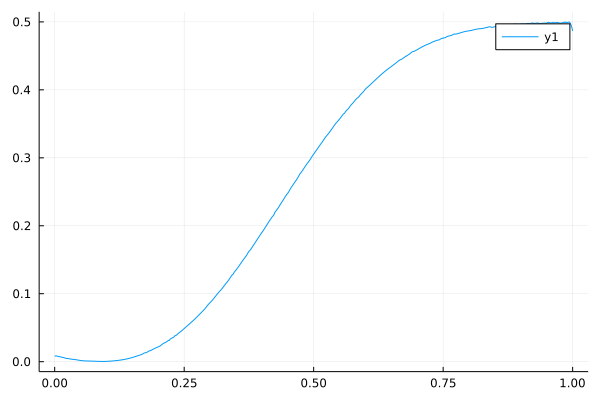

In [25]:
plot(domain,resident)

In [ ]:
plot(domain, )